# Using BGLS on Clifford and near-Clifford circuits

Here we will demonstrate how BGLS can be used to simulate sampling from both Clifford circuits, as well as near-Clifford circuits - in particular the Clifford+T universal gate set.

In [1]:
import time

import numpy as np
import matplotlib.pyplot as plt

import cirq

import bgls

Explicitly, the Clifford group consists of the Hadamard, S, and CNOT gates. We can check that an operation satisfies this criterion via the cirq protocol ```cirq.has_stabilizer_effect(op)```:

In [2]:
for gate in [cirq.H, cirq.S, cirq.CNOT]:
    assert cirq.has_stabilizer_effect(gate)

To efficiently simulate circuits composed from such gates, we can take advantage of stabilizer states. In particular, we make use of the CH-form stabilizer state as introducted in arxiv:1808.00128. This additionally tracks an overall phase, enabling efficient reconstruction of the state vector. Cirq already implements this through the ```cirq.sim.StabilizerChFormSimulationState```.

We then provide the ```bgls.utils.cirq_stabilizer_ch_bitstring_probability(state, str)``` function to compute the probability of measuring such a state as a given computational-basis bitstring:

In [3]:
qubits = cirq.LineQubit.range(3)
# create a stabilizer state trivially in the computational-basis state "101" i.e. 5 in base-10:
ch_stab_state = cirq.StabilizerChFormSimulationState(qubits=qubits, initial_state=5)
# we are then certain to measure this bitstring from the state
assert bgls.cirq_stabilizer_ch_bitstring_probability(ch_stab_state, "101") == 1.0

Sampling from such a circuit then looks much as it does for generic circuits, just substituting in the above state type and probability function. Notably, cirq still supports applying gates through ```cirq.protocols.act_on``` for pure Clifford circuits.

0: ───H───@───M('measure')───
          │   │
1: ───────X───M──────────────
              │
2: ───S───────M──────────────


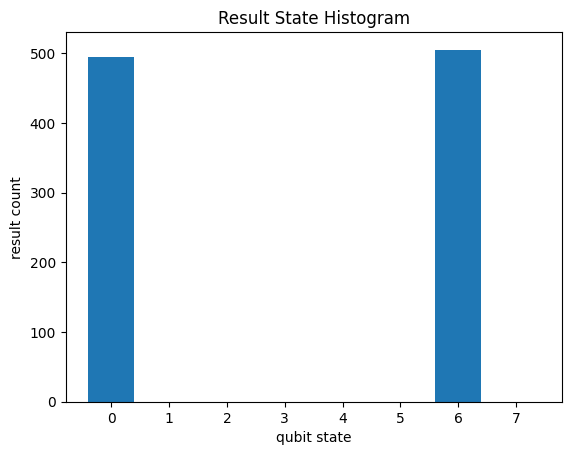

In [5]:
a, b, c = cirq.LineQubit.range(3)
circuit = cirq.Circuit(
    cirq.H(a),
    cirq.CNOT(a, b),
    cirq.S.on(c),
)
circuit = circuit + cirq.measure([a, b, c], key="measure")
print(circuit)

ch_stabilizer_simulator = bgls.Simulator(
        cirq.StabilizerChFormSimulationState(
            qubits=(a, b, c), initial_state=0
        ),
        cirq.protocols.act_on,
        bgls.utils.cirq_stabilizer_ch_bitstring_probability,
        seed=1,
    )

result = ch_stabilizer_simulator.run(circuit, repetitions=1000)
_ = cirq.plot_state_histogram(result, plt.subplot())
plt.show()

However, this protocol is rigid in that it cannot handle non-clifford gates in a circuit:

In [6]:
circuit = cirq.Circuit(
    cirq.H(a),
    cirq.CNOT(a, b),
    cirq.S.on(c),
    cirq.T.on(a),
    cirq.measure([a, b, c], key="z"),
)
ch_stabilizer_simulator = bgls.Simulator(
        cirq.StabilizerChFormSimulationState(
            qubits=(a, b, c), initial_state=0
        ),
        cirq.protocols.act_on,
        bgls.utils.cirq_stabilizer_ch_bitstring_probability,
        seed=1,
    )

try:
    result = ch_stabilizer_simulator.run(circuit, repetitions=1000)
except TypeError:
    print("act_on cannot handle non-clifford circuits!")
    

act_on cannot handle non-clifford circuits!


For near-Clifford circuits, we expand upon this by providing ```bgls.utils.apply_near_clifford_gate(op, state, rng)```. As per arxiv:1808.00128, any single-qubit diagonal rotation $R(\theta)$ can be optimally decomposed (i.e. approximately) in terms of Clifford gates as: $R(\theta) = (\cos(\theta/2) - \sin(\theta/2)) I + \sqrt 2 e^{-i\pi/4}\sin(\theta/2)S $. To obtain a universal gate set, we can include T gates which are equivalently $R(\pi/4)$. Then, whenever our simulator encounters a non-Clifford gate, ```apply_near_clifford_gate``` merely picks from the gates in the expansion weighted by their respective amplitudes, and the sampling follows one of the $2^{\#\textrm{non-Clifford gates}}$ branches in the Clifford expansion of the near-Clifford circuit.

We can then handle non-Clifford circuits by substituting out ```act_on```:

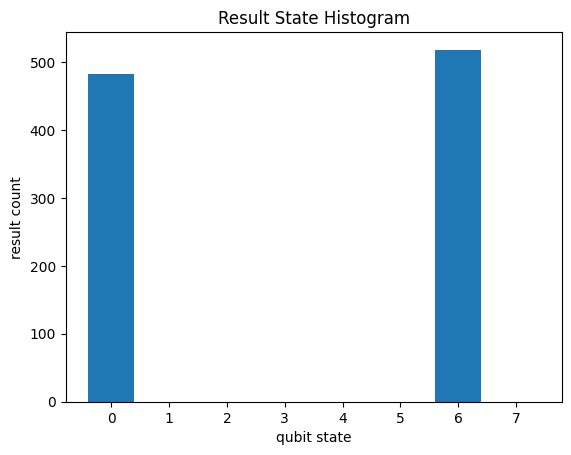

In [7]:
a, b, c = cirq.LineQubit.range(3)
circuit = cirq.Circuit(
    cirq.H(a),
    cirq.T.on(c),
    cirq.CNOT(a, b),
    cirq.S.on(c),
    cirq.measure([a, b, c], key="z"),
)
ch_stabilizer_simulator = bgls.Simulator(
        cirq.StabilizerChFormSimulationState(
            qubits=(a, b, c), initial_state=0
        ),
        bgls.utils.act_on_near_clifford,
        bgls.utils.cirq_stabilizer_ch_bitstring_probability,
        seed=1,
    )

result = ch_stabilizer_simulator.run(circuit, repetitions=1000)
_ = cirq.plot_state_histogram(result, plt.subplot())
plt.show()

We can then test behavior on larger circuits with ```cirq.testing.random_circuit(qubits, n_moments, op_density, gate_domain)```. With ```{cirq.H, cirq.CNOT, cirq.S}``` for strictly Clifford, and ```{cirq.H, cirq.CNOT, cirq.S, cirq.T}``` for near-Clifford circuits.

Here we run on an increasingly deep pure-Clifford circuit and plot runtime vs depth. We see it scales essentially linearly in depth.

In [14]:
depths = []
runtimes = []
qubits = cirq.LineQubit.range(4)
for depth in range(10, 20, 2):
    circuit = cirq.testing.random_circuit(qubits, n_moments=depth, op_density=0.5, gate_domain={cirq.H: 1, cirq.CNOT: 2, cirq.S: 1}, random_state=2)
    circuit = circuit + cirq.measure(qubits, key="measure")
    
    ch_stabilizer_simulator = bgls.Simulator(
        cirq.StabilizerChFormSimulationState(
            qubits=qubits, initial_state=0
        ),
        bgls.utils.act_on_near_clifford,
        bgls.utils.cirq_stabilizer_ch_bitstring_probability,
        seed=1,
    )

    start = time.time()
    result = ch_stabilizer_simulator.run(circuit, repetitions=1000)
    end = time.time()
    runtime = end - start
    
    depths.append(depth)
    runtimes.append(runtime)

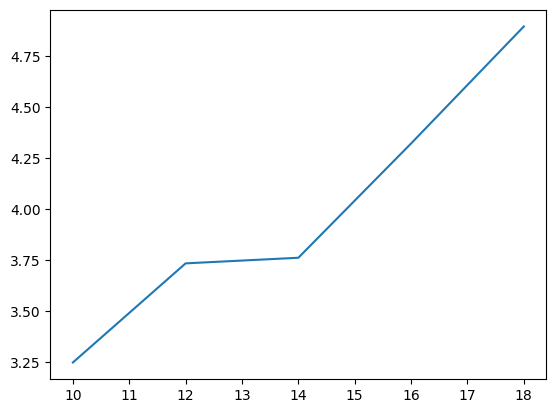

In [15]:
plt.plot(depths, runtimes)
plt.show()

Conversely here, for a fixed depth we include an increasing number of T-gates. Since each sample follows only one path in the exponentially growing expansion, we expect the output distribution to require $O(2^{\# non-Clifford})$ samples to be accurate. Thus we see a decrease in overlap with the ideal distribution for a fixed number of samples with growing T.

In [3]:
def theoretic_overlap(prob_vec: np.ndarray, result: cirq.Result):
    # returns the percent overlap of sample results with the exact probability from the state vector
    # i.e. the fraction of our results that match the ideal sample distribution
    num_matches = 0
    count = result.histogram(key="meas")
    tot_samples = sum(count.values())
    for (bitstr, cnt) in count.items():
        theoretic_cnt = int(prob_vec[int(bitstr)] * tot_samples)
        num_matches += min(cnt, theoretic_cnt)

    return num_matches / tot_samples

In [6]:
num_Ts = []
overlaps = []
qubits = cirq.LineQubit.range(4)
for num_t in range(0, 20, 3):
    circuit = cirq.testing.random_circuit(qubits, n_moments=100, op_density=0.5, gate_domain={cirq.H: 1, cirq.CNOT: 2, cirq.S: 1})
    if num_t > 0:
        inserts = []
        for t in range(num_t):
            inserts.append((np.random.randint(low=0,high=100), cirq.T.on(qubits[np.random.randint(low=0,high=len(qubits))])))
        circuit.batch_insert(inserts) # insert num_t T gates at beginning, since position in circuit doesn't affect runtime
        circuit = circuit[:-num_t] # preserve total number of gates
    circuit = circuit + cirq.measure(qubits, key="meas")

    exactsim = cirq.Simulator()
    #exactres = exactsim.simulate(circuit[:-1])
    statevec = np.power(np.abs(exactsim.simulate(circuit[:-1]).final_state_vector), 2)

    ch_stabilizer_simulator = bgls.Simulator(
        cirq.StabilizerChFormSimulationState(
            qubits=qubits, initial_state=0
        ),
        bgls.utils.act_on_near_clifford,
        bgls.utils.cirq_stabilizer_ch_bitstring_probability,
        seed=1,
    )
    result = ch_stabilizer_simulator.run(circuit, repetitions=100)
    
    overlap = theoretic_overlap(statevec, result)

    num_Ts.append(num_t)
    overlaps.append(overlap)

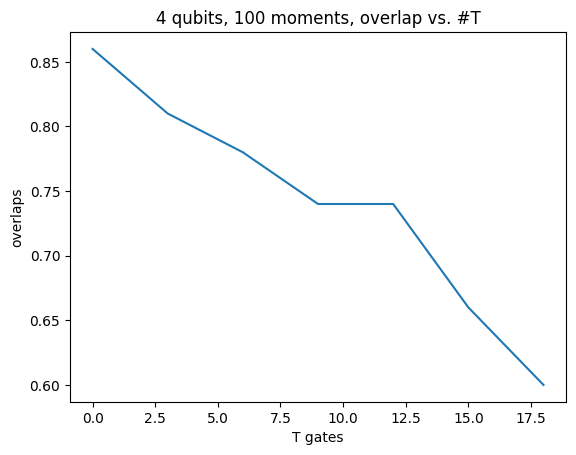

In [7]:
plt.plot(num_Ts, overlaps)
# plt.xlim(xmin=0)
# plt.ylim(ymin=0)
plt.ylabel(ylabel="overlaps")
plt.xlabel(xlabel="T gates")
plt.title(label="4 qubits, 100 moments, overlap vs. #T")
plt.show()